In [1]:
from pathlib import Path

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import tgt
import torch
import torchaudio
from pydub import AudioSegment
from scipy.signal import find_peaks

from zerosyl.wavlm import WavLM

In [2]:
# Get all the waveform and alignment paths

waveform_dir = Path("data/waveforms/LibriSpeech/dev-clean")
alignment_dir = Path("data/alignments/LibriSpeech/dev-clean")

waveform_paths = {p.stem: p for p in waveform_dir.rglob("*.flac")}
alignment_paths = {p.stem: p for p in alignment_dir.rglob("*.TextGrid")}

common_stems = sorted(waveform_paths.keys() & alignment_paths.keys())
waveform_paths = [waveform_paths[s] for s in common_stems]
alignment_paths = [alignment_paths[s] for s in common_stems]


In [3]:
# Process a random example

index = np.random.randint(len(waveform_paths))
waveform_path = waveform_paths[index]
alignment_path = alignment_paths[index]

tg = tgt.read_textgrid(alignment_path, include_empty_intervals=False)
words = [interval.text for interval in tg.get_tier_by_name("words")]
print(f"Processing {waveform_path.name}, {" ".join(words)}")

Processing 7850-73752-0016.flac, he might be enchanted but that was the talisman


In [4]:
# Functions for plotting and listening

def listen_to_segmentation(waveform_path, peaks):
    audio = AudioSegment.from_file(waveform_path)
    segments = []

    for i in range(len(peaks) - 1):
        start_ms = int(peaks[i] * 20)  
        end_ms = int(peaks[i + 1] * 20)
        segment = audio[start_ms:end_ms]
        segments.append(segment)
    combined = AudioSegment.silent(duration=0)
    for segment in segments:
        combined += segment + AudioSegment.silent(duration=500)
    return ipd.Audio(combined.export(format="wav").read(), rate=16000)

def get_frame_num(time_sec):
    return np.floor(np.round((time_sec / 20 * 1000), 1) + 0.5).astype(np.int32) 

def plot_segmentation(
    waveform, 
    tg: tgt.TextGrid,
    peaks=None,
    norms=None,
    norms_smooth=None,
    ax=None,
    title=None
):
    tMel = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        win_length=400,
        hop_length=320,
        f_min=0,
        f_max=8000,
        n_mels=128,
        center=True,
    )
    n_mels = tMel.n_mels
    tDB = torchaudio.transforms.AmplitudeToDB(top_db=80)
    melspec = tDB(tMel(waveform.cpu()))  
    mels = melspec[0].numpy()
    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(mels, aspect="auto", origin="lower")
    ax.set_ylim(0, mels.shape[0])

    if title:
        ax.set_title(title)
    
    def x_coords(n):
        return [i + 0.5 for i in range(n)]

    def sec_to_frame(s):  
        return int(np.round(s * 50))
    
    if norms is not None:
        ax.plot(x_coords(len(norms)), 10 * np.asarray(norms) + 64, color="w", linewidth=1.0, alpha=0.9)
    if norms_smooth is not None:
        ax.plot(x_coords(len(norms_smooth)), 10 * np.asarray(norms_smooth) + 64, color="r", linewidth=1.0)

    if peaks is not None:
        peaks = np.asarray(peaks, dtype=int)
        if norms_smooth is not None:
            valid = peaks[(peaks >= 0) & (peaks < len(norms_smooth))]
            yvals = 10 * np.asarray(norms_smooth)[valid] + 64
            ax.plot([p + 0.5 for p in valid], yvals, "r*", markersize=10)
        elif norms is not None:
            valid = peaks[(peaks >= 0) & (peaks < len(norms))]
            yvals = 10 * np.asarray(norms)[valid] + 64
            ax.plot([p + 0.5 for p in valid], yvals, "r*", markersize=10)
        else:
            for p in peaks:
                ax.axvline(p, color="r", linestyle="-.", linewidth=0.8)
        
    for iv in tg.get_tier_by_name("syllables"):
        start_f = sec_to_frame(float(iv.start_time))
        end_f   = sec_to_frame(float(iv.end_time))
        ax.axvline(start_f, color="w", linestyle="--", alpha=0.5, linewidth=0.8)
        ax.axvline(end_f,   color="w", linestyle="--", alpha=0.5, linewidth=0.8)
        ax.text((start_f + end_f) / 2.0, n_mels - 18,
                getattr(iv, "text", ""), color="w", fontsize=8,
                ha="center", va="center", rotation=90)
    
    for iv in tg.get_tier_by_name("syllables"):
        start_f = sec_to_frame(float(iv.start_time))
        end_f   = sec_to_frame(float(iv.end_time))
        ax.axvline(start_f, color="w", linestyle="-", alpha=1.0, linewidth=0.9)
        ax.axvline(end_f,   color="w", linestyle="-", alpha=1.0, linewidth=0.9)
    
    ax.set_xlabel("Frame")
    

In [5]:
# Segment with prominence based peak detection on the norms

def norm_promseg(feat, window_size, prominence):
    norm = np.linalg.norm(feat, axis=1)
    mu, std = np.mean(norm), np.std(norm)
    norm_z = (norm - mu) / std
    kernel = np.ones(window_size) / window_size
    pad = window_size // 2
    norm_smooth = np.convolve(np.pad(norm_z, (pad, pad), mode='edge'), kernel, mode='valid')
    peaks, _ = find_peaks(norm_smooth, prominence=prominence)
    return norm_z, norm_smooth, peaks

/home/nicolvisser/.cache/pypoetry/virtualenvs/zerosyl-Suft6ghr-py3.12/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Number of peaks detected: 16


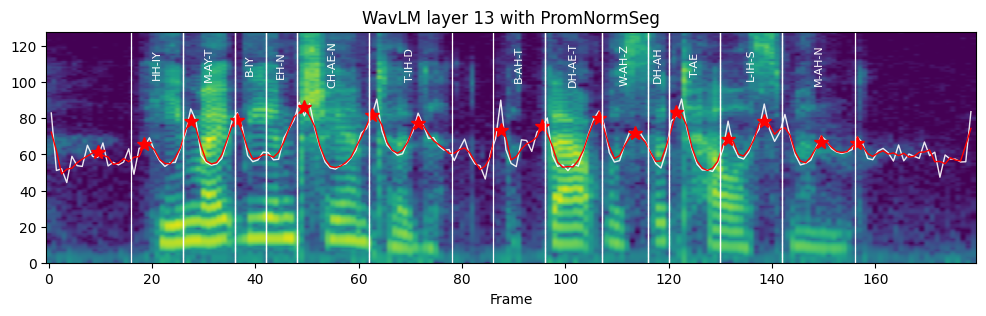

In [6]:
# Hyperparameters
LAYER = 13
WINDOW_SIZE= 3
PROMINENCE = 0.45

# Load the model
wavlm = WavLM.from_pretrained_checkpoint(Path.cwd() / "checkpoints/WavLM-Large.pt").cuda()

# Load the waveform and preprocess
waveform, sr = torchaudio.load(str(waveform_path))
if wavlm.cfg.normalize:
    waveform = torch.nn.functional.layer_norm(waveform, waveform.shape)
waveform = torch.nn.functional.pad(waveform, ((400 - 320) // 2, (400 - 320) // 2))

# Extract features
with torch.inference_mode():
    feat, _ = wavlm.extract_features(waveform.cuda(), output_layer=LAYER)
feat = feat.squeeze(0).cpu().numpy()

# Segment
norms, norms_smooth, peaks = norm_promseg(feat, window_size=WINDOW_SIZE, prominence=PROMINENCE)
print("Number of peaks detected:", len(peaks))

# Plot
plot_segmentation(
    waveform, 
    tg,
    peaks=peaks,
    norms=norms,
    norms_smooth=norms_smooth,
    title=f"WavLM layer {LAYER} with PromNormSeg"
)
listen_to_segmentation(waveform_path, peaks)